In [1]:
# data stuff:
import pandas as pd
import numpy as np
import optuna
from tqdm import tqdm

from sklearn.model_selection import TimeSeriesSplit

# plotting stuff:
import plotly.express as px
import plotly.graph_objects as go
from IPython.display import Image

# stats stuff:
import statsmodels.api as sm
from sklearn.metrics import r2_score
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.regression.linear_model import yule_walker

# silence!
import warnings
warnings.filterwarnings("ignore")

---
## The ARIMA Model:

The "Auto Regressive Integrated Moving Average" model is a simple combination of the AR and MA models plus a differencing term (the "I" stands for integration).

See page 106 of "Advanced Forecasting with Python".

Model Definition:

$$X_{t}=c+\varepsilon_{t}+ \underbrace{\sum_{i=1}^{p} \varphi_{i} X_{t-i}}_{\text{AR model}} + \underbrace{\sum_{i=1}^{q} \theta_{i} \varepsilon_{t-i}}_{\text{MA model}} + \underbrace{\delta_{t}}_{\text{differencing}}$$

---

### Import data:

In [2]:
data = sm.datasets.co2.load_pandas().data
data

,co2
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4
...,...
2001-12-01,370.3
2001-12-08,370.8
2001-12-15,371.2
2001-12-22,371.3


### Plot:

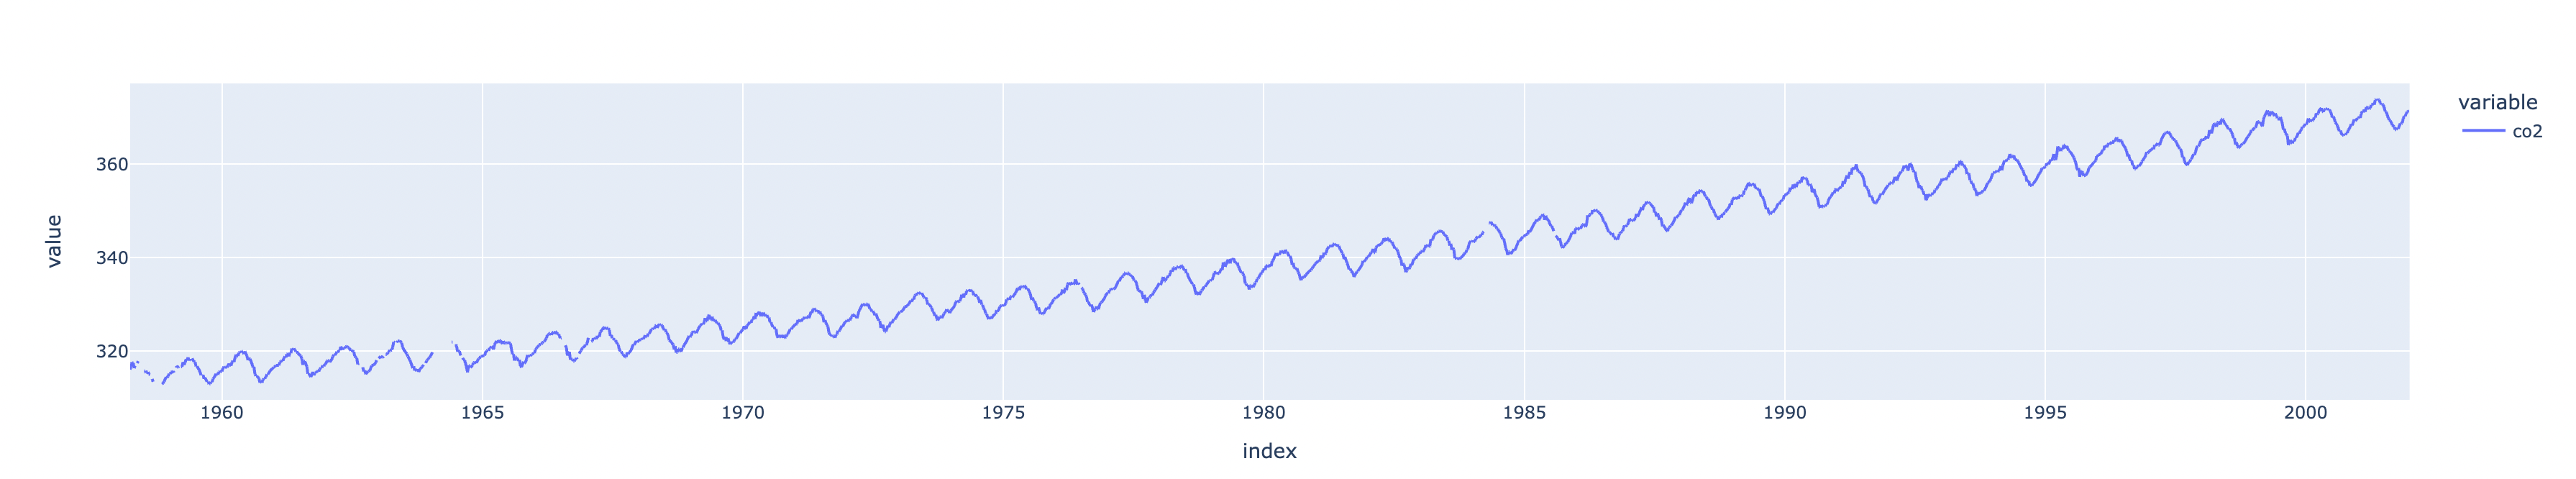

In [27]:
px.line(data)
Image(filename='./images/ch6_co2series.png', width=1600)

As we can see above, the data is non-stationary and it displays a seasonality effect. Differencing will make it stationary.

### Apply Augmented Dicky-Fuller test for stationarity:
First, we apply manual differencing.

In [4]:
# manual diff:
data_diff = data.diff().dropna()

# runs the Dicky-Fuller hypothesis test:
ADF_test = adfuller(data_diff)

# obtain p-value:
pvalue = ADF_test[1]


if pvalue < 0.05:
    print(f'p-value = {pvalue} ---> stationary')
else:
    print(f'p-value = {pvalue} ---> not stationary')

p-value = 3.374505447526158e-27 ---> stationary


The test tells us that after differencing, the data is in fact stationary.

&nbsp;

### Plot ACF and PACF:
Can we ascertain the order from the plots below?

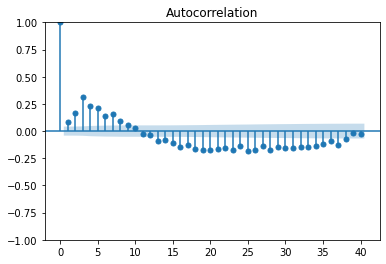

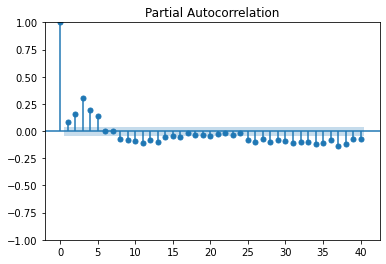

In [5]:
plot_acf(data_diff, lags=40);
plot_pacf(data_diff, lags=40);
# semicolons stops the plots from generating more than once.

The plots at lag 40 don't show any clear trend towards zero, which could mean that the data is non-stationary, however, ADF above tells us that it is indeed stationary.

What could be going on here is that the decay towards zero must be happening relatively late in the series. So we increase the number of lags.

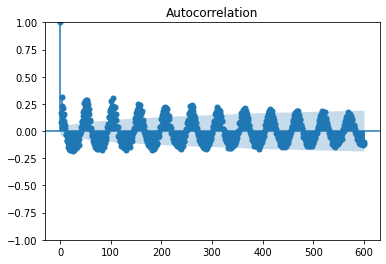

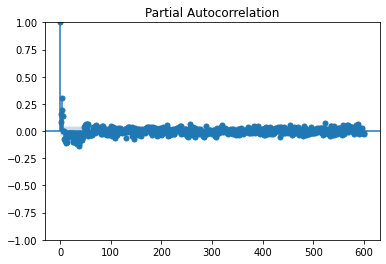

In [6]:
plot_acf(data_diff, lags=600);
plot_pacf(data_diff, lags=600);

&nbsp;

### Perform Hyperparameter tuning on AR, MA, and I parameters (orders):

In [7]:
# obtain data values as array:
data_array = data.values

# define array to hold errors:
avg_errors = []

# iterate through the different order param values:
for AR_order in tqdm(range(6)):
    for MA_order in range(6):
        for I_order in range(3):
            
            # define array to hold split error:
            errors = []
            
            # obtain time series split indices:
            tscv = TimeSeriesSplit(test_size=10)
            
            # split into train and test:
            for train_index, test_index in tscv.split(data_array):
                X_train, X_test = data_array[train_index], data_array[test_index]
                X_test_orig = X_test
                
                # forecast array:
                fcst = []
                
                # forecast 10 steps into the future:
                for step in range(10):
                    try:
                        # initialize and fit:
                        mod = ARIMA(X_train, order=(AR_order, I_order, MA_order))
                        res = mod.fit()
                        
                        # forecast one step and add forecast to array:
                        # (note: after the future step forecast, we add the test records back into the train set. Repeat 10 times)
                        fcst.append(res.forecast(steps=1))
                    except:
                        print('errorred')
                        fcst.append(-9999999.)
                    
                    # add test record back into the train set:
                    X_train = np.concatenate((X_train, X_test[0:1,:]))
                    X_test = X_test[1:]
                
                # compute errors:
                errors.append(r2_score(X_test_orig, fcst))
            
            # add results to array
            pq_result = [AR_order, I_order, MA_order, np.mean(errors)]
            
            # print and take average across the folds:
            # print(pq_result)
            avg_errors.append(pq_result)

# create dataframe with the params and errors:
avg_errors = pd.DataFrame(avg_errors)
avg_errors.columns = ['AR_order', 'I_order', 'MA_order', 'error']
avg_errors.sort_values('error', ascending=False)

 50%|████████████████████████████▌                            | 3/6 [17:40<18:51, 377.08s/it]

errorred
errorred


 67%|██████████████████████████████████████                   | 4/6 [33:14<19:54, 597.30s/it]

errorred
errorred
errorred
errorred


 83%|███████████████████████████████████████████████▌         | 5/6 [51:07<12:48, 768.67s/it]

errorred
errorred


100%|███████████████████████████████████████████████████████| 6/6 [1:09:58<00:00, 699.71s/it]


,AR_order,I_order,MA_order,error
52,2,1,5,7.381577e-01
82,4,1,3,7.311358e-01
85,4,1,4,7.304452e-01
91,5,1,0,7.244908e-01
46,2,1,3,7.235084e-01
...,...,...,...,...
102,5,0,4,-4.201109e+12
87,4,0,5,-4.915577e+12
88,4,1,5,-5.441096e+12
66,3,0,4,-6.029291e+12


&nbsp;

### Plot final results based on best params:

In [24]:
# test on the final 10 time steps:
X_train, X_test = data_array[:-10], data_array[-10:]
X_test_orig = [x[0] for x in X_test]

# forecast array:
fcst = []
for step in range(10):
    # fit:
    mod = ARIMA(X_train, order=(2,1,5))
    res = mod.fit()
    
    # forecast:
    fcst.append(res.forecast(steps=1))
    X_train = np.concatenate((X_train, X_test[0:1,:]))
    X_test = X_test[1:]

preds = [x[0] for x in fcst]

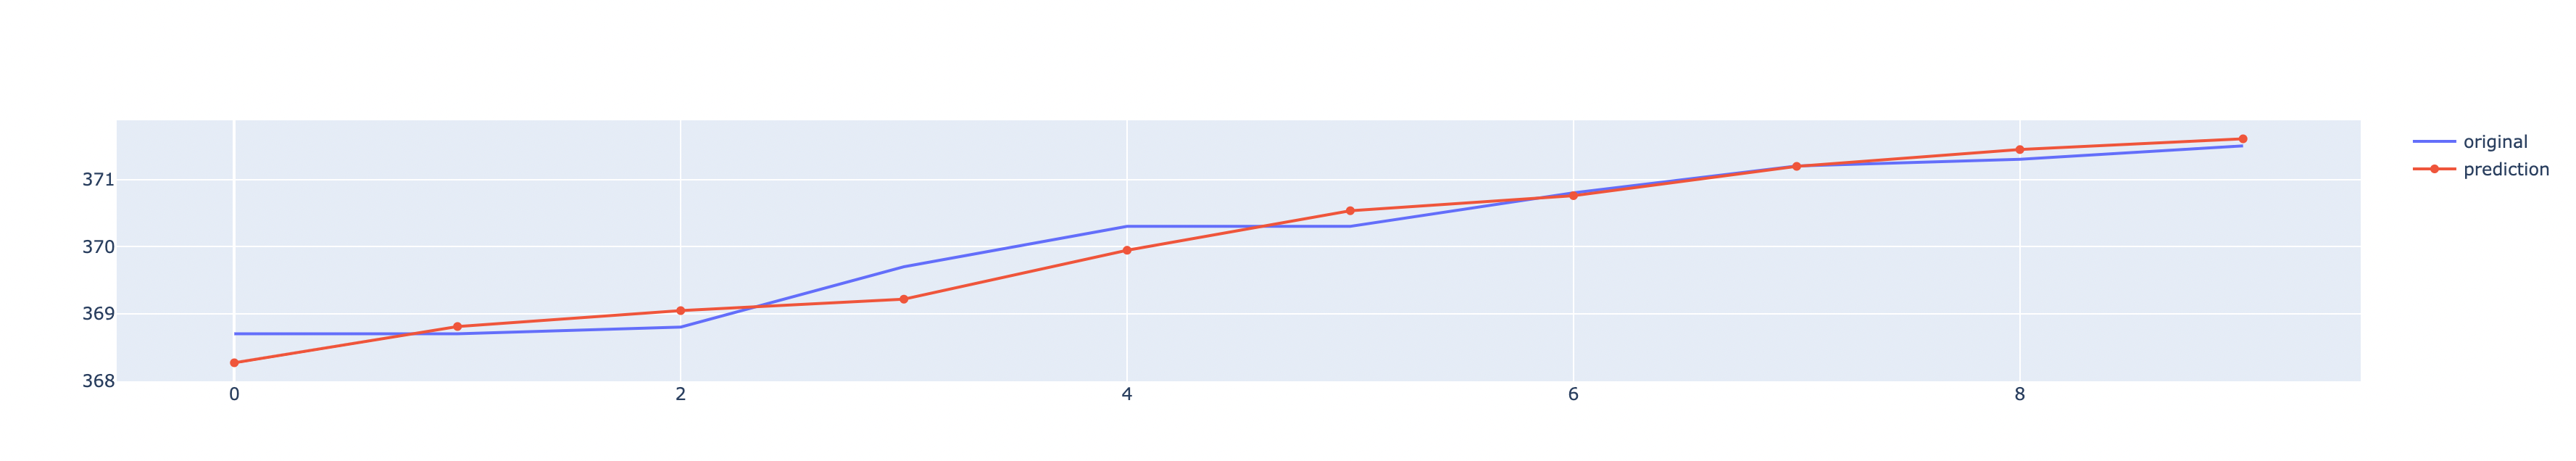

In [26]:
fig = go.Figure()
# original
fig.add_trace(go.Scatter(y=X_test_orig, mode='lines', name='original'))

# predicted:
fig.add_trace(go.Scatter(y=preds, mode='lines+markers', name='prediction'))
Image(filename='./images/ch6_co2preds.png', width=1600)